In [14]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 7)

In [15]:
MY_NAME = "David Wolever"
ARCHIVE_DIR = "/Users/wolever/Downloads/facebook-wolever-3/"

In [16]:
!pypy ./fbarchive.py "$ARCHIVE_DIR/html/messages.htm"

580k messages exported in 43s (13206 msgs/sec):
    /Users/wolever/Downloads/facebook-wolever-3//html/messages-text.tsv
    /Users/wolever/Downloads/facebook-wolever-3//html/messages-users.tsv
    /Users/wolever/Downloads/facebook-wolever-3//html/messages-threads.tsv


In [17]:
# ujson is significantly faster than stdlib's json, but stdlib's json can be used too
import ujson

messages = pd.read_csv(
   ARCHIVE_DIR + "html/messages-text.tsv", sep="\t", quoting=3,
   parse_dates=[2], converters={3: ujson.loads},
).sort_values("timestamp")
threads = pd.read_csv(ARCHIVE_DIR + "html/messages-threads.tsv", sep="\t", index_col=1)
users = pd.read_csv(ARCHIVE_DIR + "html/messages-users.tsv", sep="\t", index_col=1)

In [18]:
MY_USER_ID = users.query("user_name == %r" %(MY_NAME, )).index[0]
MY_USER_ID

1

In [19]:
def count_send_rcvd(df, rule="M"):
    msg_counts = df.set_index("timestamp")
    msg_counts["sent"] = msg_counts.user_id == MY_USER_ID
    msg_counts["rcvd"] = msg_counts["sent"] == 0
    msg_counts = msg_counts[["sent", "rcvd"]].resample(rule).sum().fillna(0)
    return msg_counts

def show_msg_plot(show):
    linestyles = ['-', '--', '-.', ':']
    for ix, col in enumerate(sorted(show.columns)):
        plt.plot(show.index, show[col], label=col, linestyle=linestyles[ix // 8])
    plt.xticks(show.index, show.index.map(lambda x: x.strftime("%Y-%b")), rotation=45);
    plt.legend()

def show_msg_plot_stacked(show):
    cols = list(sorted(show.columns))
    y = np.row_stack([show[col] for col in cols])
    plt.stackplot(show.index, y, label=cols)
    plt.xticks(show.index, show.index.map(lambda x: x.strftime("%Y-%b")), rotation=45)

def get_thread_msgs(thread_id, resample="M"):
    msgs = df[df.thread_id == thread_id]
    msgs = msgs.join(users.user_name, on="user_id")
    gd = pivot_msgs(msgs)
    return gd.resample(resample).sum().fillna(0)

def pivot_msgs(msgs):
    gd = msgs.groupby(["timestamp", "user_name"]).count().reset_index()[["timestamp", "user_name", "thread_id"]]
    gd.columns = ["timestamp", "user_name", "count"]
    return gd.pivot(columns="user_name", values="count", index="timestamp").fillna(0)

In [20]:
top_senders = messages["user_id"].value_counts()
top_senders.name = "message_counts"
top_senders = (
    users
        .join(top_senders)
        .sort_values(by="message_counts", ascending=False)
        .head(5)
        [["user_name", "message_counts"]]
)
top_senders["user_name"] = top_senders.index.map(lambda x: "(redacted %s)" %(x, ))
top_senders

,user_name,message_counts
user_id,,
1,(redacted 1),228376
357,(redacted 357),75686
372,(redacted 372),74914
356,(redacted 356),43931
224,(redacted 224),36784


In [21]:
jenny_messages = messages\
    .join(users.user_name, on="user_id")\
    .join(threads.thread_name, on="thread_id")\
    .query("thread_name == 'David Wolever, Jenny Zhang'")    
jenny_messages[105:110]

,thread_id,user_id,timestamp,text,user_name,thread_name
44638,288,1,2014-03-31 13:13:00,Okay?,David Wolever,"David Wolever, Jenny Zhang"
44635,288,1,2014-03-31 13:13:00,"Tried to say ""okay!""",David Wolever,"David Wolever, Jenny Zhang"
44634,288,1,2014-03-31 13:13:00,But iPhone,David Wolever,"David Wolever, Jenny Zhang"
44637,288,1,2014-03-31 13:13:00,Err!,David Wolever,"David Wolever, Jenny Zhang"
44633,288,315,2014-03-31 13:14:00,"OH, ha. I was like ""I didn't think that was TH...",Jenny Zhang,"David Wolever, Jenny Zhang"


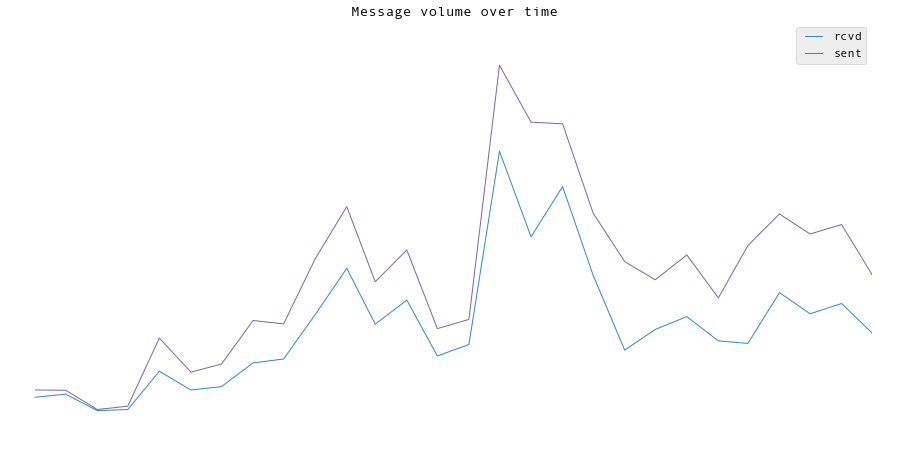

In [22]:
show_msg_plot(count_send_rcvd(jenny_messages))
plt.title("Message volume over time")
plt.axis("off"); # redacted

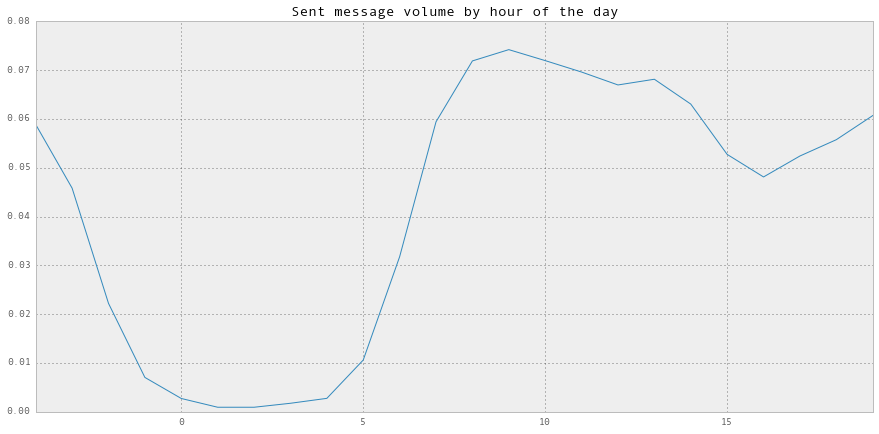

In [23]:
my_messages_by_time = messages[messages.user_id == MY_USER_ID].set_index("timestamp")
my_messages_by_hour = (
    my_messages_by_time
        .groupby(my_messages_by_time.index.hour - 4)
        .count()["text"]
)
(my_messages_by_hour / my_messages_by_hour.sum()).plot()
plt.title("Sent message volume by hour of the day");

In [24]:
top_senders_messages = messages.join(top_senders, on="user_id", how="inner")
top_senders_pivoted = pivot_msgs(top_senders_messages)
top_senders_pivoted.head(5)

user_name,(redacted 1),(redacted 224),(redacted 356),(redacted 357),(redacted 372)
timestamp,,,,,
2011-05-11 12:34:00,1.0,0.0,0.0,0.0,0.0
2011-05-11 14:10:00,1.0,0.0,0.0,0.0,0.0
2011-05-11 14:14:00,1.0,0.0,0.0,0.0,0.0
2011-05-11 16:08:00,1.0,0.0,0.0,0.0,0.0
2011-05-11 18:39:00,1.0,0.0,0.0,0.0,0.0


In [25]:
top_senders_by_hour = top_senders_pivoted.groupby(top_senders_pivoted.index.hour - 4).sum()
top_senders_by_hour.head(4) / top_senders_by_hour.sum()

user_name,(redacted 1),(redacted 224),(redacted 356),(redacted 357),(redacted 372)
-4,0.058846,0.025473,0.038947,0.037074,0.050778
-3,0.045806,0.019982,0.024174,0.025289,0.030275
-2,0.022209,0.010358,0.010221,0.009592,0.013736
-1,0.007041,0.002773,0.003733,0.003448,0.003070


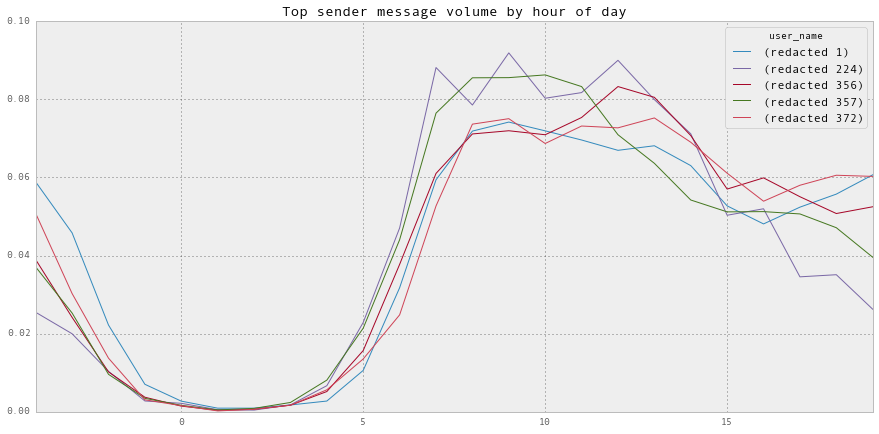

In [26]:
(top_senders_by_hour / top_senders_by_hour.sum()).plot()
plt.title("Top sender message volume by hour of day")